# VAE from Scratch

### Simple example of a VAE using the MNIST dataset

In [10]:
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt

Here we are downloading the MNIST dataset and creating the training and testing sets along with creating batches of 64. The transform is converting the images from the range [0, 255] to [0, 1].

In [11]:
# Download MNIST
transform = transforms.Compose([transforms.ToTensor()])

# Download and load the training data
trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST(root='../data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

images, labels = next(iter(trainloader))

print(f"Image batch shape: {images.shape}")
print(f"Label batch shape: {labels.shape}")

Image batch shape: torch.Size([64, 1, 28, 28])
Label batch shape: torch.Size([64])


First, we need to calculate the distribution $p_{\theta}(z|x)$ where x is the input and z is the latent space using parameters $\theta$. However, this is intractable so the encoder will approximate it, $q_{\phi}(z|x)$. This is what we are doing in the encoder - learning $\mu$ and $\sigma$ parameters to best approximate the actual latent space. The encoder architecture is simple - a few convolution layers followed by fully connected layers to get the mean and log variance.

The decoder is simply going from the latent space back to the original image: $p(x|z)$. This also includes convolutional layers upsampling the latent space to match the original input dimensions.

In [12]:
# input channels --> latent dimensions
class Encoder(nn.Module):
    def __init__(self, input_channels, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)

    def forward(self, x):
        # downsampling using the conv layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = self.flatten(x)

        z_mu = self.fc_mu(x)
        z_logvar = self.fc_logvar(x)
        
        # parameters that represent the latent space
        return z_mu, z_logvar

# latent dimensions --> output channels == input_channels
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_channels):
            super(Decoder, self).__init__()
            self.fc = nn.Linear(latent_dim, 128 * 7 * 7)
            self.conv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
            self.conv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
            self.conv3 = nn.ConvTranspose2d(32, output_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 128, 7, 7)

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        x = torch.sigmoid(self.conv3(x))

        return x

The VAE code is quite simple now that we have defined the encoder and decoder architecture - its simply combining them into one module. However, there is an important factor here. The latent space $z$ is randomly sampled. This poses the question to how we will be able to perform backpropagation. We can utilize the reparameterization trick where we can reform latent space to be a function of some random variable $\epsilon$. This will allow us to perform backpropagation.

In [13]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    # latent space z is randomly sampled - need to reparameterize 
    def reparameterize(self, z_mu, z_logvar):
        # z = mu + logvar * epsilon
        z = z_mu + torch.exp(0.5 * z_logvar) * torch.randn_like(z_logvar)
        return z
        
    def forward(self, x):
        z_mu, z_logvar = self.encoder(x)
        z = self.reparameterize(z_mu, z_logvar)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, z_mu, z_logvar

In [14]:
channels = 1
latent_dim = 20
encoder = Encoder(channels, latent_dim)
decoder = Decoder(latent_dim, channels)

vae = VAE(encoder, decoder)

I am using the loss formula as defined by Kingma & Weilling which essentially is the following: difference between original image and reconstructed + KL divergence between p(z|x) and prior p(z) (assume to follow a normal distribution)

In [15]:
def loss_function(x, reconstructed_x, mu, logvar):
    reconstruction_loss = nn.functional.binary_cross_entropy(reconstructed_x, x, reduction='sum')
   
    # 0.5 * (1 + log(sigma^2) - mu^2 - sigma^2)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return reconstruction_loss + kl_loss

optimizer = optim.Adam(vae.parameters(), lr=0.0001)

epochs = 10
def train():
    for epoch in range(epochs):
        vae.train()
        running_loss = 0
        for batch_idx, (x, _) in enumerate(trainloader):

            optimizer.zero_grad()

            reconstructed_x, mu, logvar = vae(x)
            loss = loss_function(x, reconstructed_x, mu, logvar)
            running_loss += loss
            
            loss.backward()
            optimizer.step()
    
            if (batch_idx + 1) % 100 == 0:
                    average_loss = running_loss / 100
                    print(f'Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(trainloader)}], Loss: {average_loss:.4f}')
                    running_loss = 0.0

train()

Epoch [1/10], Batch [100/938], Loss: 25740.2344
Epoch [1/10], Batch [200/938], Loss: 14759.5049
Epoch [1/10], Batch [300/938], Loss: 13623.8291
Epoch [1/10], Batch [400/938], Loss: 12560.2070
Epoch [1/10], Batch [500/938], Loss: 11482.4238
Epoch [1/10], Batch [600/938], Loss: 10501.6113
Epoch [1/10], Batch [700/938], Loss: 9840.4307
Epoch [1/10], Batch [800/938], Loss: 9411.4316
Epoch [1/10], Batch [900/938], Loss: 9076.8496
Epoch [2/10], Batch [100/938], Loss: 8661.5820
Epoch [2/10], Batch [200/938], Loss: 8388.5967
Epoch [2/10], Batch [300/938], Loss: 8307.9307
Epoch [2/10], Batch [400/938], Loss: 8164.6377
Epoch [2/10], Batch [500/938], Loss: 8029.1265
Epoch [2/10], Batch [600/938], Loss: 7948.8511
Epoch [2/10], Batch [700/938], Loss: 7864.0425
Epoch [2/10], Batch [800/938], Loss: 7778.6479
Epoch [2/10], Batch [900/938], Loss: 7709.3564
Epoch [3/10], Batch [100/938], Loss: 7569.9717
Epoch [3/10], Batch [200/938], Loss: 7575.5142
Epoch [3/10], Batch [300/938], Loss: 7495.7202
Epoch [

mu shape: torch.Size([64, 20])


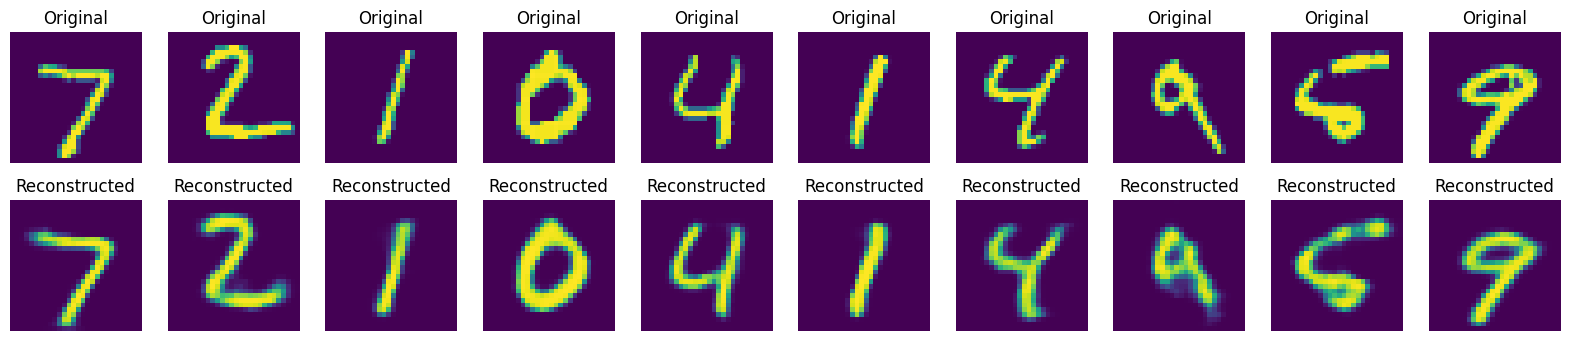

In [16]:
dataiter = iter(testloader)
images, _ = next(dataiter)

vae.eval()
with torch.no_grad():
    reconstructed_x, mu, _ = vae(images)

print(f"mu shape: {mu.shape}")

num_images = 10
plt.figure(figsize=(20, 4))

for i in range(num_images):
    # Original images
    plt.subplot(2, num_images, i + 1)
    plt.imshow(images[i].view(28, 28).cpu().numpy())
    plt.title("Original")
    plt.axis('off')
    
    # Reconstructed images
    plt.subplot(2, num_images, i + num_images + 1)
    plt.imshow(reconstructed_x[i].view(28, 28).cpu().numpy())
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()

From comparing the original and reconstructed images, the VAE appears to be able to properly represent the latent space. Although, the reconstructed images appear to be losing some resolution, the numbers are still be reconstructed well.